#### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# 探索 TF-Hub CORD-19 Swivel 嵌入向量


<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/hub/tutorials/cord_19_embeddings_keras"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a>
</td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/hub/tutorials/cord_19_embeddings_keras.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/hub/tutorials/cord_19_embeddings_keras.ipynb">     <img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">     在 GitHub 上查看源代码</a></td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/hub/tutorials/cord_19_embeddings_keras.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>
</td>
  <td><a href="https://tfhub.dev/tensorflow/cord-19/swivel-128d/3"><img src="https://tensorflow.google.cn/images/hub_logo_32px.png">查看 TF Hub 模型</a></td>
</table>

TF-Hub (https://tfhub.dev/tensorflow/cord-19/swivel-128d/3) 上的 CORD-19 Swivel 文本嵌入向量模块旨在支持研究人员分析与 COVID-19 相关的自然语言文本。这些嵌入针对 [CORD-19 数据集](https://api.semanticscholar.org/CorpusID:216056360)中文章的标题、作者、摘要、正文文本和参考文献标题进行了训练。

在此 Colab 中，我们将进行以下操作：

- 分析嵌入向量空间中语义相似的单词
- 使用 CORD-19 嵌入向量在 SciCite 数据集上训练分类器


## 设置


In [2]:
import functools
import itertools
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_hub as hub

from tqdm import trange

2022-12-14 20:29:43.485341: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 20:29:43.485455: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 20:29:43.485466: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


# 分析嵌入向量

首先，我们通过计算和绘制不同术语之间的相关矩阵来分析嵌入向量。如果嵌入向量学会了成功捕获不同单词的含义，则语义相似的单词的嵌入向量应相互靠近。我们来看一些与 COVID-19 相关的术语。

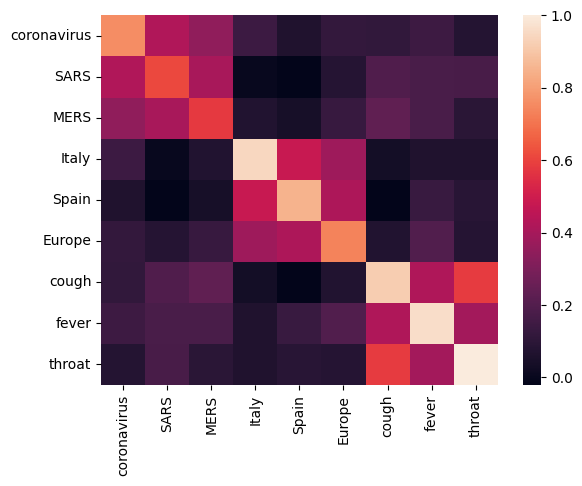

In [3]:
# Use the inner product between two embedding vectors as the similarity measure
def plot_correlation(labels, features):
  corr = np.inner(features, features)
  corr /= np.max(corr)
  sns.heatmap(corr, xticklabels=labels, yticklabels=labels)

# Generate embeddings for some terms
queries = [
  # Related viruses
  'coronavirus', 'SARS', 'MERS',
  # Regions
  'Italy', 'Spain', 'Europe',
  # Symptoms
  'cough', 'fever', 'throat'
]

module = hub.load('https://tfhub.dev/tensorflow/cord-19/swivel-128d/3')
embeddings = module(queries)

plot_correlation(queries, embeddings)

可以看到，嵌入向量成功捕获了不同术语的含义。每个单词都与其所在簇的其他单词相似（即“coronavirus”与“SARS”和“MERS”高度相关），但与其他簇的术语不同（即“SARS”与“Spain”之间的相似度接近于 0）。

现在，我们来看看如何使用这些嵌入向量解决特定任务。

## SciCite：引用意图分类

本部分介绍了将嵌入向量用于下游任务（如文本分类）的方法。我们将使用 TensorFlow 数据集中的 [SciCite 数据集](https://tensorflow.google.cn/datasets/catalog/scicite)对学术论文中的引文意图进行分类。给定一个带有学术论文引文的句子，对引文的主要意图进行分类：是背景信息、使用方法，还是比较结果。

In [4]:
builder = tfds.builder(name='scicite')
builder.download_and_prepare()
train_data, validation_data, test_data = builder.as_dataset(
    split=('train', 'validation', 'test'),
    as_supervised=True)

In [5]:
#@title Let's take a look at a few labeled examples from the training set
NUM_EXAMPLES =   10#@param {type:"integer"}

TEXT_FEATURE_NAME = builder.info.supervised_keys[0]
LABEL_NAME = builder.info.supervised_keys[1]

def label2str(numeric_label):
  m = builder.info.features[LABEL_NAME].names
  return m[numeric_label]

data = next(iter(train_data.batch(NUM_EXAMPLES)))


pd.DataFrame({
    TEXT_FEATURE_NAME: [ex.numpy().decode('utf8') for ex in data[0]],
    LABEL_NAME: [label2str(x) for x in data[1]]
})

string       label
0  The finding that BMI is closely related to TBF...      result
1  The average magnitude of the NBR increases wit...  background
2  It has been reported that NF-κB activation can...      result
3  , 2008; Quraan and Cheyne, 2008; Quraan and Ch...  background
4  5B), but, interestingly, they shared conserved...  background
5  Some investigators have noted an association o...  background
6  In our previous study, it is documented that b...  background
7  These subjects have intact cognitive function ...  background
8  Another study reported improved knee function ...  background
9  C. Data Analysis Transcription Speech samples ...      method

## 训练引用意图分类器

我们将使用 Keras 在 [SciCite 数据集](https://tensorflow.google.cn/datasets/catalog/scicite)上对分类器进行训练。我们构建一个模型，该模型使用 CORD-19 嵌入向量，并在顶部具有一个分类层。

In [6]:
#@title Hyperparameters { run: "auto" }

EMBEDDING = 'https://tfhub.dev/tensorflow/cord-19/swivel-128d/3'  #@param {type: "string"}
TRAINABLE_MODULE = False  #@param {type: "boolean"}

hub_layer = hub.KerasLayer(EMBEDDING, input_shape=[], 
                           dtype=tf.string, trainable=TRAINABLE_MODULE)

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(3))
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 keras_layer (KerasLayer)    (None, 128)               17301632  


 dense (Dense)               (None, 3)                 387       


Total params: 17,302,019


Trainable params: 387


Non-trainable params: 17,301,632


_________________________________________________________________


## 训练并评估模型

让我们训练并评估模型以查看在 SciCite 任务上的性能。

In [7]:
EPOCHS = 35#@param {type: "integer"}
BATCH_SIZE = 32#@param {type: "integer"}

history = model.fit(train_data.shuffle(10000).batch(BATCH_SIZE),
                    epochs=EPOCHS,
                    validation_data=validation_data.batch(BATCH_SIZE),
                    verbose=1)

Epoch 1/35


  1/257 [..............................] - ETA: 5:41 - loss: 1.7915 - accuracy: 0.2500

 17/257 [>.............................] - ETA: 0s - loss: 1.6719 - accuracy: 0.1452  

 34/257 [==>...........................] - ETA: 0s - loss: 1.5462 - accuracy: 0.1700

 50/257 [====>.........................] - ETA: 0s - loss: 1.4355 - accuracy: 0.2100

 67/257 [======>.......................] - ETA: 0s - loss: 1.3483 - accuracy: 0.2654

 83/257 [========>.....................] - ETA: 0s - loss: 1.2877 - accuracy: 0.3099

100/257 [==========>...................] - ETA: 0s - loss: 1.2349 - accuracy: 0.3541

117/257 [============>.................] - ETA: 0s - loss: 1.1939 - accuracy: 0.3854

134/257 [==============>...............] - ETA: 0s - loss: 1.1585 - accuracy: 0.4116

151/257 [================>.............] - ETA: 0s - loss: 1.1330 - accuracy: 0.4307

168/257 [==================>...........] - ETA: 0s - loss: 1.1098 - accuracy: 0.4464

185/257 [====================>.........] - ETA: 0s - loss: 1.0863 - accuracy: 0.4654

201/257 [======================>.......] - ETA: 0s - loss: 1.0673 - accuracy: 0.4796

217/257 [========================>.....] - ETA: 0s - loss: 1.0483 - accuracy: 0.4937

234/257 [==========================>...] - ETA: 0s - loss: 1.0320 - accuracy: 0.5061

251/257 [============================>.] - ETA: 0s - loss: 1.0218 - accuracy: 0.5133

257/257 [==============================] - 3s 5ms/step - loss: 1.0181 - accuracy: 0.5166 - val_loss: 0.8177 - val_accuracy: 0.6550


Epoch 2/35


  1/257 [..............................] - ETA: 1:32 - loss: 0.8506 - accuracy: 0.7188

 17/257 [>.............................] - ETA: 0s - loss: 0.8189 - accuracy: 0.6801  

 34/257 [==>...........................] - ETA: 0s - loss: 0.7999 - accuracy: 0.6829

 51/257 [====>.........................] - ETA: 0s - loss: 0.7913 - accuracy: 0.6820

 67/257 [======>.......................] - ETA: 0s - loss: 0.7801 - accuracy: 0.6954

 83/257 [========>.....................] - ETA: 0s - loss: 0.7804 - accuracy: 0.6924

100/257 [==========>...................] - ETA: 0s - loss: 0.7738 - accuracy: 0.6944

117/257 [============>.................] - ETA: 0s - loss: 0.7642 - accuracy: 0.6979

133/257 [==============>...............] - ETA: 0s - loss: 0.7618 - accuracy: 0.6955

149/257 [================>.............] - ETA: 0s - loss: 0.7587 - accuracy: 0.6980

166/257 [==================>...........] - ETA: 0s - loss: 0.7534 - accuracy: 0.6995

183/257 [====================>.........] - ETA: 0s - loss: 0.7485 - accuracy: 0.6998

199/257 [======================>.......] - ETA: 0s - loss: 0.7469 - accuracy: 0.7001

215/257 [========================>.....] - ETA: 0s - loss: 0.7424 - accuracy: 0.7029

232/257 [==========================>...] - ETA: 0s - loss: 0.7386 - accuracy: 0.7045

249/257 [============================>.] - ETA: 0s - loss: 0.7358 - accuracy: 0.7051

257/257 [==============================] - 1s 4ms/step - loss: 0.7353 - accuracy: 0.7049 - val_loss: 0.7010 - val_accuracy: 0.7096


Epoch 3/35


  1/257 [..............................] - ETA: 1:24 - loss: 0.7999 - accuracy: 0.6562

 17/257 [>.............................] - ETA: 0s - loss: 0.6699 - accuracy: 0.7353  

 33/257 [==>...........................] - ETA: 0s - loss: 0.6540 - accuracy: 0.7424

 48/257 [====>.........................] - ETA: 0s - loss: 0.6633 - accuracy: 0.7389

 64/257 [======>.......................] - ETA: 0s - loss: 0.6611 - accuracy: 0.7417

 79/257 [========>.....................] - ETA: 0s - loss: 0.6600 - accuracy: 0.7429

 94/257 [=========>....................] - ETA: 0s - loss: 0.6573 - accuracy: 0.7453

110/257 [===========>..................] - ETA: 0s - loss: 0.6542 - accuracy: 0.7469

126/257 [=============>................] - ETA: 0s - loss: 0.6608 - accuracy: 0.7426

142/257 [===============>..............] - ETA: 0s - loss: 0.6610 - accuracy: 0.7416

158/257 [=================>............] - ETA: 0s - loss: 0.6605 - accuracy: 0.7407

174/257 [===================>..........] - ETA: 0s - loss: 0.6574 - accuracy: 0.7423

189/257 [=====================>........] - ETA: 0s - loss: 0.6575 - accuracy: 0.7416

204/257 [======================>.......] - ETA: 0s - loss: 0.6561 - accuracy: 0.7428

220/257 [========================>.....] - ETA: 0s - loss: 0.6529 - accuracy: 0.7443

236/257 [==========================>...] - ETA: 0s - loss: 0.6529 - accuracy: 0.7435

252/257 [============================>.] - ETA: 0s - loss: 0.6499 - accuracy: 0.7449

257/257 [==============================] - 1s 4ms/step - loss: 0.6503 - accuracy: 0.7447 - val_loss: 0.6482 - val_accuracy: 0.7336


Epoch 4/35


  1/257 [..............................] - ETA: 1:33 - loss: 0.6234 - accuracy: 0.7500

 15/257 [>.............................] - ETA: 0s - loss: 0.6346 - accuracy: 0.7479  

 30/257 [==>...........................] - ETA: 0s - loss: 0.6328 - accuracy: 0.7448

 45/257 [====>.........................] - ETA: 0s - loss: 0.6352 - accuracy: 0.7500

 60/257 [======>.......................] - ETA: 0s - loss: 0.6197 - accuracy: 0.7620

 75/257 [=======>......................] - ETA: 0s - loss: 0.6152 - accuracy: 0.7617

 90/257 [=========>....................] - ETA: 0s - loss: 0.6152 - accuracy: 0.7625

105/257 [===========>..................] - ETA: 0s - loss: 0.6183 - accuracy: 0.7595

120/257 [=============>................] - ETA: 0s - loss: 0.6200 - accuracy: 0.7589

135/257 [==============>...............] - ETA: 0s - loss: 0.6185 - accuracy: 0.7590

150/257 [================>.............] - ETA: 0s - loss: 0.6152 - accuracy: 0.7592

165/257 [==================>...........] - ETA: 0s - loss: 0.6133 - accuracy: 0.7606

180/257 [====================>.........] - ETA: 0s - loss: 0.6123 - accuracy: 0.7611

195/257 [=====================>........] - ETA: 0s - loss: 0.6100 - accuracy: 0.7627

210/257 [=======================>......] - ETA: 0s - loss: 0.6091 - accuracy: 0.7634

226/257 [=========================>....] - ETA: 0s - loss: 0.6074 - accuracy: 0.7636

242/257 [===========================>..] - ETA: 0s - loss: 0.6068 - accuracy: 0.7638

257/257 [==============================] - ETA: 0s - loss: 0.6073 - accuracy: 0.7632

257/257 [==============================] - 2s 4ms/step - loss: 0.6073 - accuracy: 0.7632 - val_loss: 0.6179 - val_accuracy: 0.7434


Epoch 5/35


  1/257 [..............................] - ETA: 1:32 - loss: 0.6328 - accuracy: 0.6875

 16/257 [>.............................] - ETA: 0s - loss: 0.6189 - accuracy: 0.7422  

 32/257 [==>...........................] - ETA: 0s - loss: 0.6142 - accuracy: 0.7490

 48/257 [====>.........................] - ETA: 0s - loss: 0.6061 - accuracy: 0.7526

 64/257 [======>.......................] - ETA: 0s - loss: 0.5967 - accuracy: 0.7603

 80/257 [========>.....................] - ETA: 0s - loss: 0.5910 - accuracy: 0.7660

 96/257 [==========>...................] - ETA: 0s - loss: 0.5849 - accuracy: 0.7721

112/257 [============>.................] - ETA: 0s - loss: 0.5830 - accuracy: 0.7737

127/257 [=============>................] - ETA: 0s - loss: 0.5821 - accuracy: 0.7736

142/257 [===============>..............] - ETA: 0s - loss: 0.5837 - accuracy: 0.7731

157/257 [=================>............] - ETA: 0s - loss: 0.5811 - accuracy: 0.7731

173/257 [===================>..........] - ETA: 0s - loss: 0.5813 - accuracy: 0.7737

189/257 [=====================>........] - ETA: 0s - loss: 0.5813 - accuracy: 0.7738

205/257 [======================>.......] - ETA: 0s - loss: 0.5827 - accuracy: 0.7738

220/257 [========================>.....] - ETA: 0s - loss: 0.5827 - accuracy: 0.7733

236/257 [==========================>...] - ETA: 0s - loss: 0.5830 - accuracy: 0.7726

251/257 [============================>.] - ETA: 0s - loss: 0.5826 - accuracy: 0.7742

257/257 [==============================] - 2s 5ms/step - loss: 0.5819 - accuracy: 0.7742 - val_loss: 0.5979 - val_accuracy: 0.7544


Epoch 6/35


  1/257 [..............................] - ETA: 1:34 - loss: 0.7319 - accuracy: 0.6875

 16/257 [>.............................] - ETA: 0s - loss: 0.5620 - accuracy: 0.7988  

 32/257 [==>...........................] - ETA: 0s - loss: 0.5585 - accuracy: 0.8018

 48/257 [====>.........................] - ETA: 0s - loss: 0.5565 - accuracy: 0.7969

 64/257 [======>.......................] - ETA: 0s - loss: 0.5588 - accuracy: 0.7983

 80/257 [========>.....................] - ETA: 0s - loss: 0.5639 - accuracy: 0.7910

 96/257 [==========>...................] - ETA: 0s - loss: 0.5570 - accuracy: 0.7933

112/257 [============>.................] - ETA: 0s - loss: 0.5509 - accuracy: 0.7932

128/257 [=============>................] - ETA: 0s - loss: 0.5584 - accuracy: 0.7878

144/257 [===============>..............] - ETA: 0s - loss: 0.5634 - accuracy: 0.7845

160/257 [=================>............] - ETA: 0s - loss: 0.5618 - accuracy: 0.7852

177/257 [===================>..........] - ETA: 0s - loss: 0.5624 - accuracy: 0.7835

193/257 [=====================>........] - ETA: 0s - loss: 0.5625 - accuracy: 0.7845

209/257 [=======================>......] - ETA: 0s - loss: 0.5640 - accuracy: 0.7821

225/257 [=========================>....] - ETA: 0s - loss: 0.5664 - accuracy: 0.7800

241/257 [===========================>..] - ETA: 0s - loss: 0.5647 - accuracy: 0.7809

257/257 [==============================] - ETA: 0s - loss: 0.5655 - accuracy: 0.7796

257/257 [==============================] - 1s 4ms/step - loss: 0.5655 - accuracy: 0.7796 - val_loss: 0.5873 - val_accuracy: 0.7620


Epoch 7/35


  1/257 [..............................] - ETA: 1:27 - loss: 0.6202 - accuracy: 0.7500

 16/257 [>.............................] - ETA: 0s - loss: 0.5395 - accuracy: 0.7930  

 31/257 [==>...........................] - ETA: 0s - loss: 0.5331 - accuracy: 0.7913

 47/257 [====>.........................] - ETA: 0s - loss: 0.5362 - accuracy: 0.7866

 63/257 [======>.......................] - ETA: 0s - loss: 0.5370 - accuracy: 0.7877

 79/257 [========>.....................] - ETA: 0s - loss: 0.5383 - accuracy: 0.7880

 95/257 [==========>...................] - ETA: 0s - loss: 0.5443 - accuracy: 0.7859

111/257 [===========>..................] - ETA: 0s - loss: 0.5467 - accuracy: 0.7849

127/257 [=============>................] - ETA: 0s - loss: 0.5470 - accuracy: 0.7840

143/257 [===============>..............] - ETA: 0s - loss: 0.5497 - accuracy: 0.7828

158/257 [=================>............] - ETA: 0s - loss: 0.5521 - accuracy: 0.7814

174/257 [===================>..........] - ETA: 0s - loss: 0.5469 - accuracy: 0.7841

189/257 [=====================>........] - ETA: 0s - loss: 0.5466 - accuracy: 0.7847

205/257 [======================>.......] - ETA: 0s - loss: 0.5500 - accuracy: 0.7835

221/257 [========================>.....] - ETA: 0s - loss: 0.5535 - accuracy: 0.7820

237/257 [==========================>...] - ETA: 0s - loss: 0.5548 - accuracy: 0.7812

253/257 [============================>.] - ETA: 0s - loss: 0.5552 - accuracy: 0.7811

257/257 [==============================] - 1s 4ms/step - loss: 0.5546 - accuracy: 0.7818 - val_loss: 0.5784 - val_accuracy: 0.7653


Epoch 8/35


  1/257 [..............................] - ETA: 1:31 - loss: 0.4357 - accuracy: 0.9375

 16/257 [>.............................] - ETA: 0s - loss: 0.5409 - accuracy: 0.7930  

 32/257 [==>...........................] - ETA: 0s - loss: 0.5381 - accuracy: 0.7910

 47/257 [====>.........................] - ETA: 0s - loss: 0.5317 - accuracy: 0.7945

 63/257 [======>.......................] - ETA: 0s - loss: 0.5489 - accuracy: 0.7892

 79/257 [========>.....................] - ETA: 0s - loss: 0.5507 - accuracy: 0.7868

 95/257 [==========>...................] - ETA: 0s - loss: 0.5544 - accuracy: 0.7842

110/257 [===========>..................] - ETA: 0s - loss: 0.5511 - accuracy: 0.7844

126/257 [=============>................] - ETA: 0s - loss: 0.5494 - accuracy: 0.7850

142/257 [===============>..............] - ETA: 0s - loss: 0.5491 - accuracy: 0.7863

158/257 [=================>............] - ETA: 0s - loss: 0.5517 - accuracy: 0.7852

174/257 [===================>..........] - ETA: 0s - loss: 0.5499 - accuracy: 0.7847

190/257 [=====================>........] - ETA: 0s - loss: 0.5466 - accuracy: 0.7865

206/257 [=======================>......] - ETA: 0s - loss: 0.5441 - accuracy: 0.7875

222/257 [========================>.....] - ETA: 0s - loss: 0.5453 - accuracy: 0.7869

238/257 [==========================>...] - ETA: 0s - loss: 0.5466 - accuracy: 0.7861

254/257 [============================>.] - ETA: 0s - loss: 0.5455 - accuracy: 0.7878

257/257 [==============================] - 1s 4ms/step - loss: 0.5461 - accuracy: 0.7873 - val_loss: 0.5722 - val_accuracy: 0.7653


Epoch 9/35


  1/257 [..............................] - ETA: 1:59 - loss: 0.5102 - accuracy: 0.8438

 17/257 [>.............................] - ETA: 0s - loss: 0.5893 - accuracy: 0.7610  

 33/257 [==>...........................] - ETA: 0s - loss: 0.5824 - accuracy: 0.7680

 49/257 [====>.........................] - ETA: 0s - loss: 0.5485 - accuracy: 0.7787

 65/257 [======>.......................] - ETA: 0s - loss: 0.5462 - accuracy: 0.7803

 81/257 [========>.....................] - ETA: 0s - loss: 0.5327 - accuracy: 0.7901

 97/257 [==========>...................] - ETA: 0s - loss: 0.5363 - accuracy: 0.7877

113/257 [============>.................] - ETA: 0s - loss: 0.5424 - accuracy: 0.7857

130/257 [==============>...............] - ETA: 0s - loss: 0.5437 - accuracy: 0.7851

146/257 [================>.............] - ETA: 0s - loss: 0.5456 - accuracy: 0.7845

161/257 [=================>............] - ETA: 0s - loss: 0.5433 - accuracy: 0.7851

177/257 [===================>..........] - ETA: 0s - loss: 0.5449 - accuracy: 0.7851

193/257 [=====================>........] - ETA: 0s - loss: 0.5416 - accuracy: 0.7874

209/257 [=======================>......] - ETA: 0s - loss: 0.5450 - accuracy: 0.7859

225/257 [=========================>....] - ETA: 0s - loss: 0.5421 - accuracy: 0.7872

241/257 [===========================>..] - ETA: 0s - loss: 0.5390 - accuracy: 0.7877

257/257 [==============================] - ETA: 0s - loss: 0.5393 - accuracy: 0.7881

257/257 [==============================] - 2s 4ms/step - loss: 0.5393 - accuracy: 0.7881 - val_loss: 0.5714 - val_accuracy: 0.7642


Epoch 10/35


  1/257 [..............................] - ETA: 1:20 - loss: 0.5815 - accuracy: 0.7500

 16/257 [>.............................] - ETA: 0s - loss: 0.5743 - accuracy: 0.7832  

 31/257 [==>...........................] - ETA: 0s - loss: 0.5372 - accuracy: 0.7944

 46/257 [====>.........................] - ETA: 0s - loss: 0.5380 - accuracy: 0.7894

 61/257 [======>.......................] - ETA: 0s - loss: 0.5341 - accuracy: 0.7905

 76/257 [=======>......................] - ETA: 0s - loss: 0.5290 - accuracy: 0.7936

 91/257 [=========>....................] - ETA: 0s - loss: 0.5320 - accuracy: 0.7902

106/257 [===========>..................] - ETA: 0s - loss: 0.5347 - accuracy: 0.7886

122/257 [=============>................] - ETA: 0s - loss: 0.5351 - accuracy: 0.7887

137/257 [==============>...............] - ETA: 0s - loss: 0.5359 - accuracy: 0.7901

152/257 [================>.............] - ETA: 0s - loss: 0.5365 - accuracy: 0.7899

167/257 [==================>...........] - ETA: 0s - loss: 0.5335 - accuracy: 0.7921

182/257 [====================>.........] - ETA: 0s - loss: 0.5341 - accuracy: 0.7891

197/257 [=====================>........] - ETA: 0s - loss: 0.5378 - accuracy: 0.7873

212/257 [=======================>......] - ETA: 0s - loss: 0.5373 - accuracy: 0.7879

228/257 [=========================>....] - ETA: 0s - loss: 0.5342 - accuracy: 0.7917

244/257 [===========================>..] - ETA: 0s - loss: 0.5318 - accuracy: 0.7929

257/257 [==============================] - 1s 4ms/step - loss: 0.5346 - accuracy: 0.7907 - val_loss: 0.5644 - val_accuracy: 0.7729


Epoch 11/35


  1/257 [..............................] - ETA: 1:23 - loss: 0.5177 - accuracy: 0.8125

 17/257 [>.............................] - ETA: 0s - loss: 0.5221 - accuracy: 0.7904  

 33/257 [==>...........................] - ETA: 0s - loss: 0.5437 - accuracy: 0.7803

 50/257 [====>.........................] - ETA: 0s - loss: 0.5328 - accuracy: 0.7912

 66/257 [======>.......................] - ETA: 0s - loss: 0.5241 - accuracy: 0.7983

 83/257 [========>.....................] - ETA: 0s - loss: 0.5227 - accuracy: 0.7963

100/257 [==========>...................] - ETA: 0s - loss: 0.5233 - accuracy: 0.7931

117/257 [============>.................] - ETA: 0s - loss: 0.5241 - accuracy: 0.7922

134/257 [==============>...............] - ETA: 0s - loss: 0.5262 - accuracy: 0.7915

150/257 [================>.............] - ETA: 0s - loss: 0.5284 - accuracy: 0.7887

167/257 [==================>...........] - ETA: 0s - loss: 0.5272 - accuracy: 0.7908

184/257 [====================>.........] - ETA: 0s - loss: 0.5272 - accuracy: 0.7906

201/257 [======================>.......] - ETA: 0s - loss: 0.5294 - accuracy: 0.7901

218/257 [========================>.....] - ETA: 0s - loss: 0.5329 - accuracy: 0.7878

235/257 [==========================>...] - ETA: 0s - loss: 0.5314 - accuracy: 0.7887

252/257 [============================>.] - ETA: 0s - loss: 0.5308 - accuracy: 0.7894

257/257 [==============================] - 1s 4ms/step - loss: 0.5306 - accuracy: 0.7897 - val_loss: 0.5616 - val_accuracy: 0.7751


Epoch 12/35


  1/257 [..............................] - ETA: 1:37 - loss: 0.5690 - accuracy: 0.7188

 17/257 [>.............................] - ETA: 0s - loss: 0.5651 - accuracy: 0.7702  

 34/257 [==>...........................] - ETA: 0s - loss: 0.5392 - accuracy: 0.7812

 50/257 [====>.........................] - ETA: 0s - loss: 0.5209 - accuracy: 0.7919

 66/257 [======>.......................] - ETA: 0s - loss: 0.5214 - accuracy: 0.7888

 82/257 [========>.....................] - ETA: 0s - loss: 0.5242 - accuracy: 0.7870

 98/257 [==========>...................] - ETA: 0s - loss: 0.5299 - accuracy: 0.7867

114/257 [============>.................] - ETA: 0s - loss: 0.5314 - accuracy: 0.7867

130/257 [==============>...............] - ETA: 0s - loss: 0.5308 - accuracy: 0.7863

147/257 [================>.............] - ETA: 0s - loss: 0.5278 - accuracy: 0.7893

164/257 [==================>...........] - ETA: 0s - loss: 0.5277 - accuracy: 0.7898

180/257 [====================>.........] - ETA: 0s - loss: 0.5257 - accuracy: 0.7910

196/257 [=====================>........] - ETA: 0s - loss: 0.5280 - accuracy: 0.7902

212/257 [=======================>......] - ETA: 0s - loss: 0.5265 - accuracy: 0.7905

228/257 [=========================>....] - ETA: 0s - loss: 0.5276 - accuracy: 0.7893

244/257 [===========================>..] - ETA: 0s - loss: 0.5257 - accuracy: 0.7915

257/257 [==============================] - 1s 4ms/step - loss: 0.5263 - accuracy: 0.7918 - val_loss: 0.5580 - val_accuracy: 0.7784


Epoch 13/35


  1/257 [..............................] - ETA: 1:27 - loss: 0.7378 - accuracy: 0.7188

 17/257 [>.............................] - ETA: 0s - loss: 0.5284 - accuracy: 0.7923  

 33/257 [==>...........................] - ETA: 0s - loss: 0.5343 - accuracy: 0.7822

 49/257 [====>.........................] - ETA: 0s - loss: 0.5267 - accuracy: 0.7915

 64/257 [======>.......................] - ETA: 0s - loss: 0.5284 - accuracy: 0.7944

 80/257 [========>.....................] - ETA: 0s - loss: 0.5289 - accuracy: 0.7961

 96/257 [==========>...................] - ETA: 0s - loss: 0.5321 - accuracy: 0.7917

111/257 [===========>..................] - ETA: 0s - loss: 0.5258 - accuracy: 0.7936

127/257 [=============>................] - ETA: 0s - loss: 0.5242 - accuracy: 0.7931

143/257 [===============>..............] - ETA: 0s - loss: 0.5170 - accuracy: 0.7950

160/257 [=================>............] - ETA: 0s - loss: 0.5225 - accuracy: 0.7910

176/257 [===================>..........] - ETA: 0s - loss: 0.5202 - accuracy: 0.7942

192/257 [=====================>........] - ETA: 0s - loss: 0.5159 - accuracy: 0.7974

208/257 [=======================>......] - ETA: 0s - loss: 0.5150 - accuracy: 0.7988

224/257 [=========================>....] - ETA: 0s - loss: 0.5168 - accuracy: 0.7979

240/257 [===========================>..] - ETA: 0s - loss: 0.5206 - accuracy: 0.7953

256/257 [============================>.] - ETA: 0s - loss: 0.5238 - accuracy: 0.7935

257/257 [==============================] - 1s 4ms/step - loss: 0.5238 - accuracy: 0.7935 - val_loss: 0.5563 - val_accuracy: 0.7806


Epoch 14/35


  1/257 [..............................] - ETA: 1:30 - loss: 0.6356 - accuracy: 0.7188

 17/257 [>.............................] - ETA: 0s - loss: 0.5183 - accuracy: 0.7886  

 33/257 [==>...........................] - ETA: 0s - loss: 0.5110 - accuracy: 0.7841

 49/257 [====>.........................] - ETA: 0s - loss: 0.5028 - accuracy: 0.7985

 64/257 [======>.......................] - ETA: 0s - loss: 0.5128 - accuracy: 0.7969

 80/257 [========>.....................] - ETA: 0s - loss: 0.5231 - accuracy: 0.7930

 95/257 [==========>...................] - ETA: 0s - loss: 0.5241 - accuracy: 0.7901

111/257 [===========>..................] - ETA: 0s - loss: 0.5269 - accuracy: 0.7911

126/257 [=============>................] - ETA: 0s - loss: 0.5211 - accuracy: 0.7934

141/257 [===============>..............] - ETA: 0s - loss: 0.5199 - accuracy: 0.7948

157/257 [=================>............] - ETA: 0s - loss: 0.5244 - accuracy: 0.7932

174/257 [===================>..........] - ETA: 0s - loss: 0.5248 - accuracy: 0.7936

190/257 [=====================>........] - ETA: 0s - loss: 0.5231 - accuracy: 0.7936

206/257 [=======================>......] - ETA: 0s - loss: 0.5238 - accuracy: 0.7929

222/257 [========================>.....] - ETA: 0s - loss: 0.5224 - accuracy: 0.7931

238/257 [==========================>...] - ETA: 0s - loss: 0.5222 - accuracy: 0.7931

254/257 [============================>.] - ETA: 0s - loss: 0.5211 - accuracy: 0.7931

257/257 [==============================] - 1s 4ms/step - loss: 0.5210 - accuracy: 0.7934 - val_loss: 0.5561 - val_accuracy: 0.7784


Epoch 15/35


  1/257 [..............................] - ETA: 1:16 - loss: 0.4313 - accuracy: 0.8125

 16/257 [>.............................] - ETA: 0s - loss: 0.5061 - accuracy: 0.8066  

 32/257 [==>...........................] - ETA: 0s - loss: 0.5120 - accuracy: 0.8008

 47/257 [====>.........................] - ETA: 0s - loss: 0.5259 - accuracy: 0.7979

 63/257 [======>.......................] - ETA: 0s - loss: 0.5339 - accuracy: 0.7981

 79/257 [========>.....................] - ETA: 0s - loss: 0.5270 - accuracy: 0.7998

 95/257 [==========>...................] - ETA: 0s - loss: 0.5250 - accuracy: 0.7980

110/257 [===========>..................] - ETA: 0s - loss: 0.5183 - accuracy: 0.7994

126/257 [=============>................] - ETA: 0s - loss: 0.5257 - accuracy: 0.7929

142/257 [===============>..............] - ETA: 0s - loss: 0.5232 - accuracy: 0.7949

158/257 [=================>............] - ETA: 0s - loss: 0.5278 - accuracy: 0.7919

174/257 [===================>..........] - ETA: 0s - loss: 0.5220 - accuracy: 0.7944

191/257 [=====================>........] - ETA: 0s - loss: 0.5217 - accuracy: 0.7952

207/257 [=======================>......] - ETA: 0s - loss: 0.5218 - accuracy: 0.7935

223/257 [=========================>....] - ETA: 0s - loss: 0.5186 - accuracy: 0.7948

239/257 [==========================>...] - ETA: 0s - loss: 0.5188 - accuracy: 0.7954

255/257 [============================>.] - ETA: 0s - loss: 0.5181 - accuracy: 0.7956

257/257 [==============================] - 1s 4ms/step - loss: 0.5182 - accuracy: 0.7955 - val_loss: 0.5576 - val_accuracy: 0.7762


Epoch 16/35


  1/257 [..............................] - ETA: 1:28 - loss: 0.6778 - accuracy: 0.7188

 16/257 [>.............................] - ETA: 0s - loss: 0.4777 - accuracy: 0.8184  

 31/257 [==>...........................] - ETA: 0s - loss: 0.4927 - accuracy: 0.8044

 47/257 [====>.........................] - ETA: 0s - loss: 0.5077 - accuracy: 0.7972

 63/257 [======>.......................] - ETA: 0s - loss: 0.5079 - accuracy: 0.7966

 78/257 [========>.....................] - ETA: 0s - loss: 0.5107 - accuracy: 0.7977

 94/257 [=========>....................] - ETA: 0s - loss: 0.5133 - accuracy: 0.7945

109/257 [===========>..................] - ETA: 0s - loss: 0.5110 - accuracy: 0.7970

124/257 [=============>................] - ETA: 0s - loss: 0.5103 - accuracy: 0.7984

139/257 [===============>..............] - ETA: 0s - loss: 0.5160 - accuracy: 0.7952

154/257 [================>.............] - ETA: 0s - loss: 0.5164 - accuracy: 0.7961

169/257 [==================>...........] - ETA: 0s - loss: 0.5197 - accuracy: 0.7931

184/257 [====================>.........] - ETA: 0s - loss: 0.5245 - accuracy: 0.7901

200/257 [======================>.......] - ETA: 0s - loss: 0.5194 - accuracy: 0.7923

216/257 [========================>.....] - ETA: 0s - loss: 0.5180 - accuracy: 0.7927

232/257 [==========================>...] - ETA: 0s - loss: 0.5187 - accuracy: 0.7928

248/257 [===========================>..] - ETA: 0s - loss: 0.5167 - accuracy: 0.7932

257/257 [==============================] - 1s 4ms/step - loss: 0.5169 - accuracy: 0.7930 - val_loss: 0.5511 - val_accuracy: 0.7806


Epoch 17/35


  1/257 [..............................] - ETA: 1:20 - loss: 0.6364 - accuracy: 0.7500

 16/257 [>.............................] - ETA: 0s - loss: 0.4944 - accuracy: 0.8066  

 31/257 [==>...........................] - ETA: 0s - loss: 0.4964 - accuracy: 0.8054

 46/257 [====>.........................] - ETA: 0s - loss: 0.4901 - accuracy: 0.8098

 61/257 [======>.......................] - ETA: 0s - loss: 0.4918 - accuracy: 0.8053

 76/257 [=======>......................] - ETA: 0s - loss: 0.5016 - accuracy: 0.7998

 91/257 [=========>....................] - ETA: 0s - loss: 0.4992 - accuracy: 0.8019

106/257 [===========>..................] - ETA: 0s - loss: 0.5092 - accuracy: 0.7969

121/257 [=============>................] - ETA: 0s - loss: 0.5082 - accuracy: 0.7991

137/257 [==============>...............] - ETA: 0s - loss: 0.5103 - accuracy: 0.8000

152/257 [================>.............] - ETA: 0s - loss: 0.5096 - accuracy: 0.8004

166/257 [==================>...........] - ETA: 0s - loss: 0.5098 - accuracy: 0.7999

181/257 [====================>.........] - ETA: 0s - loss: 0.5067 - accuracy: 0.8009

196/257 [=====================>........] - ETA: 0s - loss: 0.5090 - accuracy: 0.7996

212/257 [=======================>......] - ETA: 0s - loss: 0.5096 - accuracy: 0.8000

227/257 [=========================>....] - ETA: 0s - loss: 0.5105 - accuracy: 0.7982

242/257 [===========================>..] - ETA: 0s - loss: 0.5134 - accuracy: 0.7960

257/257 [==============================] - ETA: 0s - loss: 0.5145 - accuracy: 0.7956

257/257 [==============================] - 1s 4ms/step - loss: 0.5145 - accuracy: 0.7956 - val_loss: 0.5515 - val_accuracy: 0.7784


Epoch 18/35


  1/257 [..............................] - ETA: 1:30 - loss: 0.5357 - accuracy: 0.6875

 16/257 [>.............................] - ETA: 0s - loss: 0.5458 - accuracy: 0.7637  

 32/257 [==>...........................] - ETA: 0s - loss: 0.5490 - accuracy: 0.7764

 47/257 [====>.........................] - ETA: 0s - loss: 0.5432 - accuracy: 0.7832

 63/257 [======>.......................] - ETA: 0s - loss: 0.5394 - accuracy: 0.7847

 79/257 [========>.....................] - ETA: 0s - loss: 0.5525 - accuracy: 0.7785

 95/257 [==========>...................] - ETA: 0s - loss: 0.5441 - accuracy: 0.7826

111/257 [===========>..................] - ETA: 0s - loss: 0.5367 - accuracy: 0.7858

126/257 [=============>................] - ETA: 0s - loss: 0.5285 - accuracy: 0.7879

142/257 [===============>..............] - ETA: 0s - loss: 0.5213 - accuracy: 0.7909

157/257 [=================>............] - ETA: 0s - loss: 0.5220 - accuracy: 0.7900

172/257 [===================>..........] - ETA: 0s - loss: 0.5192 - accuracy: 0.7914

187/257 [====================>.........] - ETA: 0s - loss: 0.5196 - accuracy: 0.7926

202/257 [======================>.......] - ETA: 0s - loss: 0.5199 - accuracy: 0.7922

217/257 [========================>.....] - ETA: 0s - loss: 0.5155 - accuracy: 0.7942

233/257 [==========================>...] - ETA: 0s - loss: 0.5140 - accuracy: 0.7952

249/257 [============================>.] - ETA: 0s - loss: 0.5154 - accuracy: 0.7942

257/257 [==============================] - 1s 4ms/step - loss: 0.5130 - accuracy: 0.7956 - val_loss: 0.5511 - val_accuracy: 0.7740


Epoch 19/35


  1/257 [..............................] - ETA: 1:26 - loss: 0.4312 - accuracy: 0.8750

 16/257 [>.............................] - ETA: 0s - loss: 0.5038 - accuracy: 0.8086  

 32/257 [==>...........................] - ETA: 0s - loss: 0.5040 - accuracy: 0.8125

 48/257 [====>.........................] - ETA: 0s - loss: 0.5041 - accuracy: 0.8086

 63/257 [======>.......................] - ETA: 0s - loss: 0.5071 - accuracy: 0.8051

 79/257 [========>.....................] - ETA: 0s - loss: 0.5078 - accuracy: 0.8038

 95/257 [==========>...................] - ETA: 0s - loss: 0.5206 - accuracy: 0.8000

111/257 [===========>..................] - ETA: 0s - loss: 0.5152 - accuracy: 0.8010

127/257 [=============>................] - ETA: 0s - loss: 0.5121 - accuracy: 0.8019

143/257 [===============>..............] - ETA: 0s - loss: 0.5065 - accuracy: 0.8024

159/257 [=================>............] - ETA: 0s - loss: 0.5056 - accuracy: 0.8029

175/257 [===================>..........] - ETA: 0s - loss: 0.5062 - accuracy: 0.8048

192/257 [=====================>........] - ETA: 0s - loss: 0.5056 - accuracy: 0.8031

209/257 [=======================>......] - ETA: 0s - loss: 0.5113 - accuracy: 0.7995

225/257 [=========================>....] - ETA: 0s - loss: 0.5088 - accuracy: 0.7994

241/257 [===========================>..] - ETA: 0s - loss: 0.5110 - accuracy: 0.7984

257/257 [==============================] - ETA: 0s - loss: 0.5115 - accuracy: 0.7969

257/257 [==============================] - 1s 4ms/step - loss: 0.5115 - accuracy: 0.7969 - val_loss: 0.5495 - val_accuracy: 0.7795


Epoch 20/35


  1/257 [..............................] - ETA: 1:22 - loss: 0.3325 - accuracy: 0.9062

 16/257 [>.............................] - ETA: 0s - loss: 0.5076 - accuracy: 0.7930  

 32/257 [==>...........................] - ETA: 0s - loss: 0.5178 - accuracy: 0.7900

 48/257 [====>.........................] - ETA: 0s - loss: 0.5209 - accuracy: 0.7936

 64/257 [======>.......................] - ETA: 0s - loss: 0.5135 - accuracy: 0.7983

 80/257 [========>.....................] - ETA: 0s - loss: 0.5148 - accuracy: 0.7953

 97/257 [==========>...................] - ETA: 0s - loss: 0.5163 - accuracy: 0.7935

114/257 [============>.................] - ETA: 0s - loss: 0.5177 - accuracy: 0.7930

131/257 [==============>...............] - ETA: 0s - loss: 0.5129 - accuracy: 0.7953

147/257 [================>.............] - ETA: 0s - loss: 0.5109 - accuracy: 0.7972

163/257 [==================>...........] - ETA: 0s - loss: 0.5093 - accuracy: 0.7977

179/257 [===================>..........] - ETA: 0s - loss: 0.5115 - accuracy: 0.7954

196/257 [=====================>........] - ETA: 0s - loss: 0.5148 - accuracy: 0.7956

212/257 [=======================>......] - ETA: 0s - loss: 0.5147 - accuracy: 0.7954

228/257 [=========================>....] - ETA: 0s - loss: 0.5129 - accuracy: 0.7954

244/257 [===========================>..] - ETA: 0s - loss: 0.5100 - accuracy: 0.7959

257/257 [==============================] - 1s 4ms/step - loss: 0.5112 - accuracy: 0.7955 - val_loss: 0.5504 - val_accuracy: 0.7860


Epoch 21/35


  1/257 [..............................] - ETA: 1:21 - loss: 0.6950 - accuracy: 0.6875

 16/257 [>.............................] - ETA: 0s - loss: 0.4979 - accuracy: 0.7949  

 32/257 [==>...........................] - ETA: 0s - loss: 0.4986 - accuracy: 0.8008

 48/257 [====>.........................] - ETA: 0s - loss: 0.4977 - accuracy: 0.7988

 63/257 [======>.......................] - ETA: 0s - loss: 0.5109 - accuracy: 0.7971

 79/257 [========>.....................] - ETA: 0s - loss: 0.5035 - accuracy: 0.7994

 94/257 [=========>....................] - ETA: 0s - loss: 0.5046 - accuracy: 0.8012

110/257 [===========>..................] - ETA: 0s - loss: 0.5088 - accuracy: 0.8011

126/257 [=============>................] - ETA: 0s - loss: 0.5113 - accuracy: 0.7986

142/257 [===============>..............] - ETA: 0s - loss: 0.5119 - accuracy: 0.7975

158/257 [=================>............] - ETA: 0s - loss: 0.5076 - accuracy: 0.7996

174/257 [===================>..........] - ETA: 0s - loss: 0.5060 - accuracy: 0.8021

190/257 [=====================>........] - ETA: 0s - loss: 0.5083 - accuracy: 0.8003

206/257 [=======================>......] - ETA: 0s - loss: 0.5087 - accuracy: 0.8001

222/257 [========================>.....] - ETA: 0s - loss: 0.5099 - accuracy: 0.7987

238/257 [==========================>...] - ETA: 0s - loss: 0.5118 - accuracy: 0.7973

254/257 [============================>.] - ETA: 0s - loss: 0.5088 - accuracy: 0.7982

257/257 [==============================] - 1s 4ms/step - loss: 0.5090 - accuracy: 0.7980 - val_loss: 0.5485 - val_accuracy: 0.7773


Epoch 22/35


  1/257 [..............................] - ETA: 1:27 - loss: 0.3435 - accuracy: 0.8750

 16/257 [>.............................] - ETA: 0s - loss: 0.4391 - accuracy: 0.8320  

 32/257 [==>...........................] - ETA: 0s - loss: 0.4954 - accuracy: 0.8047

 48/257 [====>.........................] - ETA: 0s - loss: 0.5146 - accuracy: 0.7962

 64/257 [======>.......................] - ETA: 0s - loss: 0.5193 - accuracy: 0.7866

 80/257 [========>.....................] - ETA: 0s - loss: 0.5145 - accuracy: 0.7902

 96/257 [==========>...................] - ETA: 0s - loss: 0.5141 - accuracy: 0.7913

112/257 [============>.................] - ETA: 0s - loss: 0.5109 - accuracy: 0.7985

128/257 [=============>................] - ETA: 0s - loss: 0.5027 - accuracy: 0.8027

144/257 [===============>..............] - ETA: 0s - loss: 0.4985 - accuracy: 0.8058

160/257 [=================>............] - ETA: 0s - loss: 0.4986 - accuracy: 0.8070

176/257 [===================>..........] - ETA: 0s - loss: 0.4959 - accuracy: 0.8074

192/257 [=====================>........] - ETA: 0s - loss: 0.5030 - accuracy: 0.8035

208/257 [=======================>......] - ETA: 0s - loss: 0.5064 - accuracy: 0.8008

224/257 [=========================>....] - ETA: 0s - loss: 0.5050 - accuracy: 0.8009

240/257 [===========================>..] - ETA: 0s - loss: 0.5047 - accuracy: 0.8013

256/257 [============================>.] - ETA: 0s - loss: 0.5084 - accuracy: 0.7988

257/257 [==============================] - 1s 4ms/step - loss: 0.5083 - accuracy: 0.7989 - val_loss: 0.5496 - val_accuracy: 0.7817


Epoch 23/35


  1/257 [..............................] - ETA: 1:26 - loss: 0.5253 - accuracy: 0.8438

 15/257 [>.............................] - ETA: 0s - loss: 0.4940 - accuracy: 0.8042  

 30/257 [==>...........................] - ETA: 0s - loss: 0.4899 - accuracy: 0.8010

 45/257 [====>.........................] - ETA: 0s - loss: 0.5134 - accuracy: 0.7937

 60/257 [======>.......................] - ETA: 0s - loss: 0.5075 - accuracy: 0.7984

 75/257 [=======>......................] - ETA: 0s - loss: 0.5145 - accuracy: 0.7933

 90/257 [=========>....................] - ETA: 0s - loss: 0.5210 - accuracy: 0.7896

105/257 [===========>..................] - ETA: 0s - loss: 0.5284 - accuracy: 0.7866

120/257 [=============>................] - ETA: 0s - loss: 0.5241 - accuracy: 0.7885

136/257 [==============>...............] - ETA: 0s - loss: 0.5264 - accuracy: 0.7886

152/257 [================>.............] - ETA: 0s - loss: 0.5225 - accuracy: 0.7921

168/257 [==================>...........] - ETA: 0s - loss: 0.5181 - accuracy: 0.7930

184/257 [====================>.........] - ETA: 0s - loss: 0.5177 - accuracy: 0.7911

199/257 [======================>.......] - ETA: 0s - loss: 0.5139 - accuracy: 0.7941

214/257 [=======================>......] - ETA: 0s - loss: 0.5113 - accuracy: 0.7938

229/257 [=========================>....] - ETA: 0s - loss: 0.5110 - accuracy: 0.7931

244/257 [===========================>..] - ETA: 0s - loss: 0.5077 - accuracy: 0.7956

257/257 [==============================] - 1s 4ms/step - loss: 0.5066 - accuracy: 0.7969 - val_loss: 0.5476 - val_accuracy: 0.7860


Epoch 24/35


  1/257 [..............................] - ETA: 1:19 - loss: 0.5100 - accuracy: 0.7812

 16/257 [>.............................] - ETA: 0s - loss: 0.5504 - accuracy: 0.7793  

 31/257 [==>...........................] - ETA: 0s - loss: 0.5093 - accuracy: 0.7994

 46/257 [====>.........................] - ETA: 0s - loss: 0.5105 - accuracy: 0.7996

 61/257 [======>.......................] - ETA: 0s - loss: 0.5098 - accuracy: 0.8012

 76/257 [=======>......................] - ETA: 0s - loss: 0.5128 - accuracy: 0.7981

 91/257 [=========>....................] - ETA: 0s - loss: 0.5084 - accuracy: 0.8012

106/257 [===========>..................] - ETA: 0s - loss: 0.5028 - accuracy: 0.8028

122/257 [=============>................] - ETA: 0s - loss: 0.4982 - accuracy: 0.8038

137/257 [==============>...............] - ETA: 0s - loss: 0.4994 - accuracy: 0.8006

153/257 [================>.............] - ETA: 0s - loss: 0.5059 - accuracy: 0.7998

168/257 [==================>...........] - ETA: 0s - loss: 0.5060 - accuracy: 0.7985

184/257 [====================>.........] - ETA: 0s - loss: 0.5056 - accuracy: 0.7987

200/257 [======================>.......] - ETA: 0s - loss: 0.5062 - accuracy: 0.7969

216/257 [========================>.....] - ETA: 0s - loss: 0.5058 - accuracy: 0.7977

232/257 [==========================>...] - ETA: 0s - loss: 0.5065 - accuracy: 0.7970

248/257 [===========================>..] - ETA: 0s - loss: 0.5065 - accuracy: 0.7976

257/257 [==============================] - 1s 4ms/step - loss: 0.5067 - accuracy: 0.7977 - val_loss: 0.5461 - val_accuracy: 0.7806


Epoch 25/35


  1/257 [..............................] - ETA: 1:31 - loss: 0.3978 - accuracy: 0.8438

 16/257 [>.............................] - ETA: 0s - loss: 0.4907 - accuracy: 0.8066  

 31/257 [==>...........................] - ETA: 0s - loss: 0.4851 - accuracy: 0.8175

 46/257 [====>.........................] - ETA: 0s - loss: 0.5036 - accuracy: 0.8057

 61/257 [======>.......................] - ETA: 0s - loss: 0.4965 - accuracy: 0.8079

 76/257 [=======>......................] - ETA: 0s - loss: 0.4926 - accuracy: 0.8104

 91/257 [=========>....................] - ETA: 0s - loss: 0.4882 - accuracy: 0.8128

106/257 [===========>..................] - ETA: 0s - loss: 0.4994 - accuracy: 0.8051

121/257 [=============>................] - ETA: 0s - loss: 0.5094 - accuracy: 0.8001

136/257 [==============>...............] - ETA: 0s - loss: 0.5120 - accuracy: 0.7978

152/257 [================>.............] - ETA: 0s - loss: 0.5125 - accuracy: 0.7965

168/257 [==================>...........] - ETA: 0s - loss: 0.5131 - accuracy: 0.7961

184/257 [====================>.........] - ETA: 0s - loss: 0.5115 - accuracy: 0.7962

200/257 [======================>.......] - ETA: 0s - loss: 0.5108 - accuracy: 0.7975

216/257 [========================>.....] - ETA: 0s - loss: 0.5088 - accuracy: 0.7983

232/257 [==========================>...] - ETA: 0s - loss: 0.5058 - accuracy: 0.7981

248/257 [===========================>..] - ETA: 0s - loss: 0.5039 - accuracy: 0.7988

257/257 [==============================] - 1s 4ms/step - loss: 0.5055 - accuracy: 0.7983 - val_loss: 0.5472 - val_accuracy: 0.7882


Epoch 26/35


  1/257 [..............................] - ETA: 1:30 - loss: 0.3938 - accuracy: 0.8438

 16/257 [>.............................] - ETA: 0s - loss: 0.4872 - accuracy: 0.8066  

 31/257 [==>...........................] - ETA: 0s - loss: 0.4929 - accuracy: 0.7994

 46/257 [====>.........................] - ETA: 0s - loss: 0.4842 - accuracy: 0.8084

 61/257 [======>.......................] - ETA: 0s - loss: 0.5035 - accuracy: 0.8023

 76/257 [=======>......................] - ETA: 0s - loss: 0.5107 - accuracy: 0.8022

 91/257 [=========>....................] - ETA: 0s - loss: 0.5149 - accuracy: 0.7953

106/257 [===========>..................] - ETA: 0s - loss: 0.5084 - accuracy: 0.7983

121/257 [=============>................] - ETA: 0s - loss: 0.5102 - accuracy: 0.7949

137/257 [==============>...............] - ETA: 0s - loss: 0.5022 - accuracy: 0.7995

153/257 [================>.............] - ETA: 0s - loss: 0.5021 - accuracy: 0.7982

168/257 [==================>...........] - ETA: 0s - loss: 0.5038 - accuracy: 0.7991

183/257 [====================>.........] - ETA: 0s - loss: 0.5039 - accuracy: 0.7980

199/257 [======================>.......] - ETA: 0s - loss: 0.5020 - accuracy: 0.7998

214/257 [=======================>......] - ETA: 0s - loss: 0.5046 - accuracy: 0.7980

230/257 [=========================>....] - ETA: 0s - loss: 0.5041 - accuracy: 0.7966

245/257 [===========================>..] - ETA: 0s - loss: 0.5045 - accuracy: 0.7971

257/257 [==============================] - 1s 4ms/step - loss: 0.5048 - accuracy: 0.7970 - val_loss: 0.5492 - val_accuracy: 0.7817


Epoch 27/35


  1/257 [..............................] - ETA: 1:28 - loss: 0.3994 - accuracy: 0.8750

 16/257 [>.............................] - ETA: 0s - loss: 0.4709 - accuracy: 0.8164  

 32/257 [==>...........................] - ETA: 0s - loss: 0.4798 - accuracy: 0.8174

 48/257 [====>.........................] - ETA: 0s - loss: 0.4908 - accuracy: 0.8066

 64/257 [======>.......................] - ETA: 0s - loss: 0.4945 - accuracy: 0.8052

 80/257 [========>.....................] - ETA: 0s - loss: 0.4845 - accuracy: 0.8098

 96/257 [==========>...................] - ETA: 0s - loss: 0.4961 - accuracy: 0.8001

112/257 [============>.................] - ETA: 0s - loss: 0.5011 - accuracy: 0.7980

128/257 [=============>................] - ETA: 0s - loss: 0.5025 - accuracy: 0.7993

144/257 [===============>..............] - ETA: 0s - loss: 0.5102 - accuracy: 0.7984

159/257 [=================>............] - ETA: 0s - loss: 0.5079 - accuracy: 0.7980

175/257 [===================>..........] - ETA: 0s - loss: 0.5070 - accuracy: 0.7986

191/257 [=====================>........] - ETA: 0s - loss: 0.5102 - accuracy: 0.7981

207/257 [=======================>......] - ETA: 0s - loss: 0.5113 - accuracy: 0.7976

223/257 [=========================>....] - ETA: 0s - loss: 0.5069 - accuracy: 0.8002

239/257 [==========================>...] - ETA: 0s - loss: 0.5053 - accuracy: 0.8009

255/257 [============================>.] - ETA: 0s - loss: 0.5048 - accuracy: 0.8000

257/257 [==============================] - 1s 4ms/step - loss: 0.5043 - accuracy: 0.8002 - val_loss: 0.5504 - val_accuracy: 0.7806


Epoch 28/35


  1/257 [..............................] - ETA: 1:35 - loss: 0.6980 - accuracy: 0.7500

 17/257 [>.............................] - ETA: 0s - loss: 0.5453 - accuracy: 0.7757  

 33/257 [==>...........................] - ETA: 0s - loss: 0.5187 - accuracy: 0.7860

 49/257 [====>.........................] - ETA: 0s - loss: 0.5065 - accuracy: 0.7940

 65/257 [======>.......................] - ETA: 0s - loss: 0.4999 - accuracy: 0.7995

 81/257 [========>.....................] - ETA: 0s - loss: 0.4899 - accuracy: 0.8021

 97/257 [==========>...................] - ETA: 0s - loss: 0.4928 - accuracy: 0.7999

113/257 [============>.................] - ETA: 0s - loss: 0.5046 - accuracy: 0.7918

128/257 [=============>................] - ETA: 0s - loss: 0.5068 - accuracy: 0.7915

144/257 [===============>..............] - ETA: 0s - loss: 0.5073 - accuracy: 0.7906

160/257 [=================>............] - ETA: 0s - loss: 0.4996 - accuracy: 0.7971

177/257 [===================>..........] - ETA: 0s - loss: 0.5077 - accuracy: 0.7941

194/257 [=====================>........] - ETA: 0s - loss: 0.5053 - accuracy: 0.7957

210/257 [=======================>......] - ETA: 0s - loss: 0.5031 - accuracy: 0.7978

227/257 [=========================>....] - ETA: 0s - loss: 0.5056 - accuracy: 0.7971

243/257 [===========================>..] - ETA: 0s - loss: 0.5057 - accuracy: 0.7976

257/257 [==============================] - 1s 4ms/step - loss: 0.5034 - accuracy: 0.7988 - val_loss: 0.5464 - val_accuracy: 0.7871


Epoch 29/35


  1/257 [..............................] - ETA: 1:17 - loss: 0.8141 - accuracy: 0.5938

 16/257 [>.............................] - ETA: 0s - loss: 0.5020 - accuracy: 0.7930  

 32/257 [==>...........................] - ETA: 0s - loss: 0.4926 - accuracy: 0.8018

 48/257 [====>.........................] - ETA: 0s - loss: 0.5150 - accuracy: 0.7878

 64/257 [======>.......................] - ETA: 0s - loss: 0.5114 - accuracy: 0.7905

 80/257 [========>.....................] - ETA: 0s - loss: 0.5182 - accuracy: 0.7926

 96/257 [==========>...................] - ETA: 0s - loss: 0.5204 - accuracy: 0.7923

112/257 [============>.................] - ETA: 0s - loss: 0.5191 - accuracy: 0.7932

128/257 [=============>................] - ETA: 0s - loss: 0.5167 - accuracy: 0.7974

144/257 [===============>..............] - ETA: 0s - loss: 0.5133 - accuracy: 0.7977

160/257 [=================>............] - ETA: 0s - loss: 0.5057 - accuracy: 0.8008

175/257 [===================>..........] - ETA: 0s - loss: 0.5070 - accuracy: 0.7993

191/257 [=====================>........] - ETA: 0s - loss: 0.5068 - accuracy: 0.7992

207/257 [=======================>......] - ETA: 0s - loss: 0.5052 - accuracy: 0.7995

223/257 [=========================>....] - ETA: 0s - loss: 0.5041 - accuracy: 0.8000

239/257 [==========================>...] - ETA: 0s - loss: 0.5047 - accuracy: 0.8001

254/257 [============================>.] - ETA: 0s - loss: 0.5048 - accuracy: 0.7987

257/257 [==============================] - 1s 4ms/step - loss: 0.5029 - accuracy: 0.7995 - val_loss: 0.5462 - val_accuracy: 0.7871


Epoch 30/35


  1/257 [..............................] - ETA: 1:29 - loss: 0.5106 - accuracy: 0.8125

 16/257 [>.............................] - ETA: 0s - loss: 0.5145 - accuracy: 0.8086  

 32/257 [==>...........................] - ETA: 0s - loss: 0.5055 - accuracy: 0.8047

 48/257 [====>.........................] - ETA: 0s - loss: 0.5070 - accuracy: 0.8073

 64/257 [======>.......................] - ETA: 0s - loss: 0.5073 - accuracy: 0.8047

 80/257 [========>.....................] - ETA: 0s - loss: 0.5039 - accuracy: 0.8023

 97/257 [==========>...................] - ETA: 0s - loss: 0.4983 - accuracy: 0.8048

113/257 [============>.................] - ETA: 0s - loss: 0.5046 - accuracy: 0.8037

128/257 [=============>................] - ETA: 0s - loss: 0.5069 - accuracy: 0.8008

144/257 [===============>..............] - ETA: 0s - loss: 0.5059 - accuracy: 0.7995

160/257 [=================>............] - ETA: 0s - loss: 0.5029 - accuracy: 0.7996

176/257 [===================>..........] - ETA: 0s - loss: 0.5016 - accuracy: 0.8013

193/257 [=====================>........] - ETA: 0s - loss: 0.4999 - accuracy: 0.8025

209/257 [=======================>......] - ETA: 0s - loss: 0.5035 - accuracy: 0.8001

225/257 [=========================>....] - ETA: 0s - loss: 0.5036 - accuracy: 0.8010

241/257 [===========================>..] - ETA: 0s - loss: 0.5024 - accuracy: 0.8012

257/257 [==============================] - ETA: 0s - loss: 0.5021 - accuracy: 0.8019

257/257 [==============================] - 1s 4ms/step - loss: 0.5021 - accuracy: 0.8019 - val_loss: 0.5489 - val_accuracy: 0.7860


Epoch 31/35


  1/257 [..............................] - ETA: 1:31 - loss: 0.5640 - accuracy: 0.6875

 15/257 [>.............................] - ETA: 0s - loss: 0.5463 - accuracy: 0.7854  

 30/257 [==>...........................] - ETA: 0s - loss: 0.5482 - accuracy: 0.7875

 46/257 [====>.........................] - ETA: 0s - loss: 0.5326 - accuracy: 0.7955

 61/257 [======>.......................] - ETA: 0s - loss: 0.5236 - accuracy: 0.8002

 76/257 [=======>......................] - ETA: 0s - loss: 0.5117 - accuracy: 0.8043

 91/257 [=========>....................] - ETA: 0s - loss: 0.5025 - accuracy: 0.8077

106/257 [===========>..................] - ETA: 0s - loss: 0.5096 - accuracy: 0.8001

122/257 [=============>................] - ETA: 0s - loss: 0.5077 - accuracy: 0.7989

138/257 [===============>..............] - ETA: 0s - loss: 0.5101 - accuracy: 0.7962

153/257 [================>.............] - ETA: 0s - loss: 0.5100 - accuracy: 0.7974

168/257 [==================>...........] - ETA: 0s - loss: 0.5127 - accuracy: 0.7971

184/257 [====================>.........] - ETA: 0s - loss: 0.5110 - accuracy: 0.7970

199/257 [======================>.......] - ETA: 0s - loss: 0.5167 - accuracy: 0.7940

215/257 [========================>.....] - ETA: 0s - loss: 0.5103 - accuracy: 0.7969

231/257 [=========================>....] - ETA: 0s - loss: 0.5075 - accuracy: 0.7984

247/257 [===========================>..] - ETA: 0s - loss: 0.5044 - accuracy: 0.8006

257/257 [==============================] - 1s 4ms/step - loss: 0.5018 - accuracy: 0.8013 - val_loss: 0.5471 - val_accuracy: 0.7860


Epoch 32/35


  1/257 [..............................] - ETA: 1:19 - loss: 0.5992 - accuracy: 0.7188

 17/257 [>.............................] - ETA: 0s - loss: 0.5195 - accuracy: 0.7739  

 33/257 [==>...........................] - ETA: 0s - loss: 0.5027 - accuracy: 0.7841

 49/257 [====>.........................] - ETA: 0s - loss: 0.5140 - accuracy: 0.7864

 65/257 [======>.......................] - ETA: 0s - loss: 0.4986 - accuracy: 0.7986

 82/257 [========>.....................] - ETA: 0s - loss: 0.4971 - accuracy: 0.7954

 98/257 [==========>...................] - ETA: 0s - loss: 0.4952 - accuracy: 0.7956

115/257 [============>.................] - ETA: 0s - loss: 0.5003 - accuracy: 0.7935

131/257 [==============>...............] - ETA: 0s - loss: 0.5024 - accuracy: 0.7929

147/257 [================>.............] - ETA: 0s - loss: 0.5012 - accuracy: 0.7951

163/257 [==================>...........] - ETA: 0s - loss: 0.4983 - accuracy: 0.7974

179/257 [===================>..........] - ETA: 0s - loss: 0.4959 - accuracy: 0.8022

195/257 [=====================>........] - ETA: 0s - loss: 0.4998 - accuracy: 0.7998

211/257 [=======================>......] - ETA: 0s - loss: 0.4957 - accuracy: 0.8024

227/257 [=========================>....] - ETA: 0s - loss: 0.4955 - accuracy: 0.8025

243/257 [===========================>..] - ETA: 0s - loss: 0.4975 - accuracy: 0.8021

257/257 [==============================] - 1s 5ms/step - loss: 0.5010 - accuracy: 0.8019 - val_loss: 0.5455 - val_accuracy: 0.7915


Epoch 33/35


  1/257 [..............................] - ETA: 1:31 - loss: 0.3518 - accuracy: 0.9375

 16/257 [>.............................] - ETA: 0s - loss: 0.5454 - accuracy: 0.8008  

 32/257 [==>...........................] - ETA: 0s - loss: 0.5117 - accuracy: 0.8125

 48/257 [====>.........................] - ETA: 0s - loss: 0.4923 - accuracy: 0.8158

 64/257 [======>.......................] - ETA: 0s - loss: 0.4927 - accuracy: 0.8105

 80/257 [========>.....................] - ETA: 0s - loss: 0.4984 - accuracy: 0.8055

 96/257 [==========>...................] - ETA: 0s - loss: 0.5011 - accuracy: 0.8018

112/257 [============>.................] - ETA: 0s - loss: 0.4988 - accuracy: 0.8022

128/257 [=============>................] - ETA: 0s - loss: 0.4977 - accuracy: 0.8018

145/257 [===============>..............] - ETA: 0s - loss: 0.4992 - accuracy: 0.8013

161/257 [=================>............] - ETA: 0s - loss: 0.4985 - accuracy: 0.8026

176/257 [===================>..........] - ETA: 0s - loss: 0.4960 - accuracy: 0.8038

192/257 [=====================>........] - ETA: 0s - loss: 0.4964 - accuracy: 0.8032

208/257 [=======================>......] - ETA: 0s - loss: 0.5005 - accuracy: 0.8012

224/257 [=========================>....] - ETA: 0s - loss: 0.4980 - accuracy: 0.8030

240/257 [===========================>..] - ETA: 0s - loss: 0.4986 - accuracy: 0.8031

256/257 [============================>.] - ETA: 0s - loss: 0.5006 - accuracy: 0.8021

257/257 [==============================] - 1s 4ms/step - loss: 0.5007 - accuracy: 0.8021 - val_loss: 0.5469 - val_accuracy: 0.7904


Epoch 34/35


  1/257 [..............................] - ETA: 1:25 - loss: 0.5398 - accuracy: 0.8125

 17/257 [>.............................] - ETA: 0s - loss: 0.4848 - accuracy: 0.8107  

 33/257 [==>...........................] - ETA: 0s - loss: 0.4776 - accuracy: 0.8049

 49/257 [====>.........................] - ETA: 0s - loss: 0.4944 - accuracy: 0.7940

 65/257 [======>.......................] - ETA: 0s - loss: 0.5013 - accuracy: 0.7947

 81/257 [========>.....................] - ETA: 0s - loss: 0.5131 - accuracy: 0.7909

 97/257 [==========>...................] - ETA: 0s - loss: 0.5103 - accuracy: 0.7967

113/257 [============>.................] - ETA: 0s - loss: 0.5100 - accuracy: 0.7973

129/257 [==============>...............] - ETA: 0s - loss: 0.5102 - accuracy: 0.7975

145/257 [===============>..............] - ETA: 0s - loss: 0.5084 - accuracy: 0.7978

161/257 [=================>............] - ETA: 0s - loss: 0.5090 - accuracy: 0.7977

177/257 [===================>..........] - ETA: 0s - loss: 0.5043 - accuracy: 0.8003

193/257 [=====================>........] - ETA: 0s - loss: 0.5037 - accuracy: 0.8012

209/257 [=======================>......] - ETA: 0s - loss: 0.5018 - accuracy: 0.8013

225/257 [=========================>....] - ETA: 0s - loss: 0.5019 - accuracy: 0.7996

241/257 [===========================>..] - ETA: 0s - loss: 0.4984 - accuracy: 0.8023

257/257 [==============================] - ETA: 0s - loss: 0.5001 - accuracy: 0.8013

257/257 [==============================] - 1s 4ms/step - loss: 0.5001 - accuracy: 0.8013 - val_loss: 0.5479 - val_accuracy: 0.7871


Epoch 35/35


  1/257 [..............................] - ETA: 1:35 - loss: 0.5115 - accuracy: 0.7812

 16/257 [>.............................] - ETA: 0s - loss: 0.5316 - accuracy: 0.7969  

 32/257 [==>...........................] - ETA: 0s - loss: 0.5008 - accuracy: 0.8008

 48/257 [====>.........................] - ETA: 0s - loss: 0.5131 - accuracy: 0.7969

 64/257 [======>.......................] - ETA: 0s - loss: 0.5016 - accuracy: 0.8018

 81/257 [========>.....................] - ETA: 0s - loss: 0.5136 - accuracy: 0.7967

 98/257 [==========>...................] - ETA: 0s - loss: 0.5190 - accuracy: 0.7953

114/257 [============>.................] - ETA: 0s - loss: 0.5104 - accuracy: 0.7993

130/257 [==============>...............] - ETA: 0s - loss: 0.5106 - accuracy: 0.7986

147/257 [================>.............] - ETA: 0s - loss: 0.5098 - accuracy: 0.7974

163/257 [==================>...........] - ETA: 0s - loss: 0.5087 - accuracy: 0.7977

179/257 [===================>..........] - ETA: 0s - loss: 0.5060 - accuracy: 0.7991

195/257 [=====================>........] - ETA: 0s - loss: 0.5007 - accuracy: 0.8018

211/257 [=======================>......] - ETA: 0s - loss: 0.5031 - accuracy: 0.8005

227/257 [=========================>....] - ETA: 0s - loss: 0.5022 - accuracy: 0.8020

243/257 [===========================>..] - ETA: 0s - loss: 0.4994 - accuracy: 0.8031

257/257 [==============================] - 1s 4ms/step - loss: 0.5004 - accuracy: 0.8028 - val_loss: 0.5455 - val_accuracy: 0.7882


In [8]:
from matplotlib import pyplot as plt
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

/tmpfs/tmp/ipykernel_21774/4094752860.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


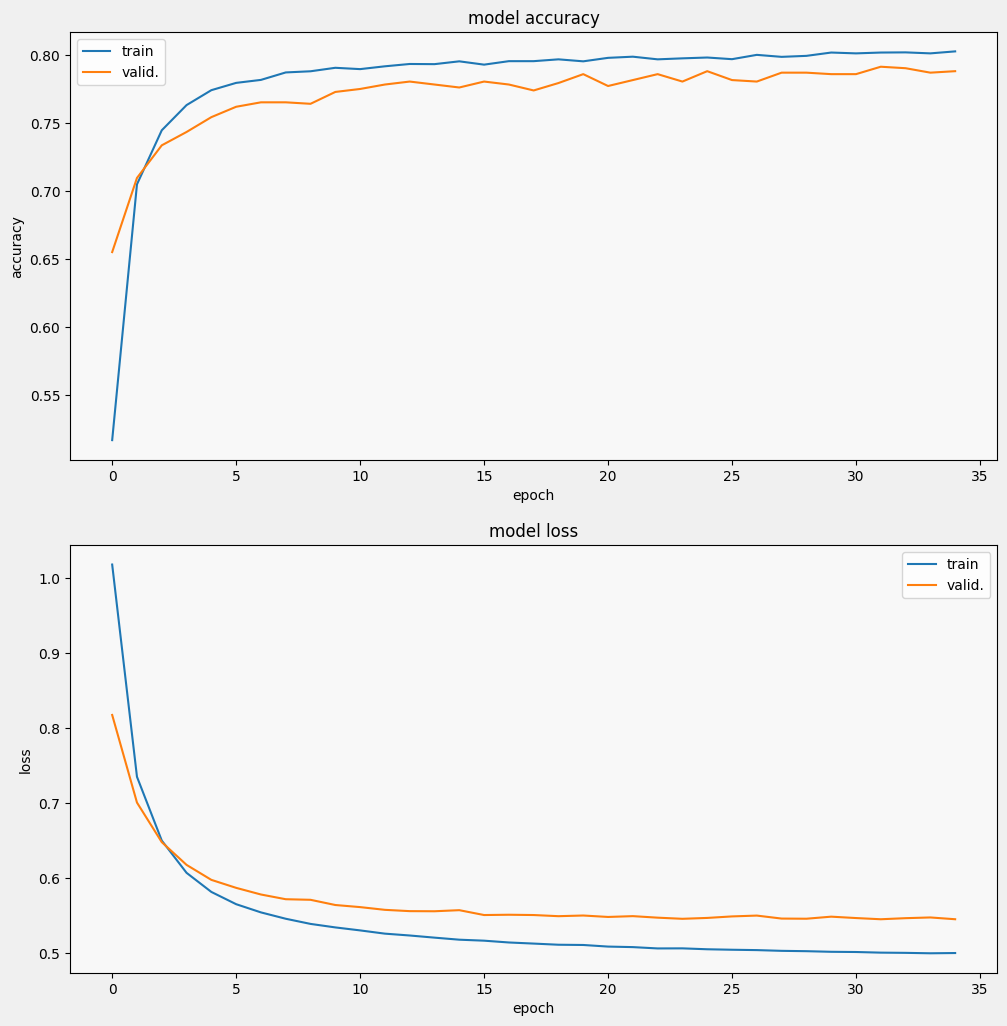

In [9]:
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

## 评估模型

我们来看看模型的表现。模型将返回两个值：损失（表示错误的数字，值越低越好）和准确率。

In [10]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print('%s: %.3f' % (name, value))

4/4 - 0s - loss: 0.5379 - accuracy: 0.7848 - 291ms/epoch - 73ms/step


loss: 0.538
accuracy: 0.785


可以看到，损失迅速减小，而准确率迅速提高。我们绘制一些样本来检查预测与真实标签的关系：

In [11]:
prediction_dataset = next(iter(test_data.batch(20)))

prediction_texts = [ex.numpy().decode('utf8') for ex in prediction_dataset[0]]
prediction_labels = [label2str(x) for x in prediction_dataset[1]]

predictions = [
    label2str(x) for x in np.argmax(model.predict(prediction_texts), axis=-1)]


pd.DataFrame({
    TEXT_FEATURE_NAME: prediction_texts,
    LABEL_NAME: prediction_labels,
    'prediction': predictions
})

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 150ms/step


string       label  prediction
0   The diffraction grating, LED, and split detect...  background      method
1   Our ideas are based on a previous paper [4] de...  background      method
2   Our finding is consistent with the literature ...      result      result
3   Test scores from each of the cognitive domains...      method      method
4   The optimization algorithm was set to maximize...      method      method
5   To quantify the extent of substitution saturat...      method      method
6   Examples of gesture control are based on the e...      method      method
7   The identification of these features has been ...      method  background
8   Postulated mechanisms for observed effects of ...  background  background
9   The right inferior phrenic artery is the most ...  background  background
10  [8] presented an approach for estimating the t...  background      method
11  Similar structures were observed in M10 cells ...      result      method
12  Cytotoxic effects of cobalt chloride were repo...  background      result
13  However, prolonged incubation of latex enzyme ...  background  background
14  …and travels great distances, resulting in a s...  background  background
15  The images fused using region selection; MSD, ...      method      method
16  These findings were expected, as EMG activity ...      result  background
17  The model has been extended to both 2D and 3D ...      method  background
18  Therefore, many authors claim comprehensive nu...  background      method
19  Similar to Ab40, IAPP-GI populates an aggregat...  background  background

可以看到，对于此随机样本，模型大多数时候都会预测正确的标签，这表明它可以很好地嵌入科学句子。

# 后续计划

现在，您已经对 TF-Hub 中的 CORD-19 Swivel 嵌入向量有了更多了解，我们鼓励您参加 CORD-19 Kaggle 竞赛，为从 COVID-19 相关学术文本中获得更深入的科学洞见做出贡献。

- 参加 [CORD-19 Kaggle Challenge](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge)
- 详细了解 [COVID-19 开放研究数据集 (CORD-19)](https://api.semanticscholar.org/CorpusID:216056360)
- 访问 https://tfhub.dev/tensorflow/cord-19/swivel-128d/3，参阅文档并详细了解 TF-Hub 嵌入向量
- 使用 [TensorFlow Embedding Projector](http://projector.tensorflow.org/?config=https://storage.googleapis.com/tfhub-examples/tensorflow/cord-19/swivel-128d/3/tensorboard/projector_config.json) 探索 CORD-19 嵌入向量空间